In [1]:
import pandas as pd
import numpy as np
import pathlib as pl

from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from statsmodels.stats.multitest import multipletests

from scipy.stats import mannwhitneyu, fisher_exact, pearsonr, kruskal

In [2]:
import sys
sys.path.append("../../FinalCode/")
import download.download as dwnl
import utils.plotting as plting
#import adVMP.adVMP_discovery as discov
#import adVMP.adVMP_plots as advmpplt
#import adVMP.adVMP_crossval as advmpcross

In [5]:
import warnings
warnings.filterwarnings(action='once')

In [12]:
pd.options.mode.chained_assignment = None

In [3]:
# For figures
colors = sns.color_palette("muted")
palette = {"Normal": colors[0], "NADJ-A": colors[3], "NADJ-C": colors[2], "Adenoma": colors[3], "SSL": colors[4], "Cancer": colors[5]}
fig_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/ArticleFigures/unit")

In [4]:
base_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/sesame_processed_EPIC/")
base_dir4 = pl.Path("/Users/josephineyates/Documents/CRC_polyp/sesame_processed_EPIC4/")

data_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/FinalData/")

bad_probes = pd.read_csv(data_dir / "auxiliary" / "sketchy_probe_list_epic.csv",index_col=0).values.ravel()
sample_origin_path = pl.Path(data_dir / "clinical" / "sample_origin_wbatch.csv")

clinical_path = pl.Path(data_dir / "clinical" / "cleaned_clinical_reduced_diet.csv")
target_path = pl.Path(data_dir / "clinical" / "targets.csv")

In [6]:
EPIC2_b, EPIC2_clin, EPIC2_samples, EPIC2_phenotypes, EPIC3_b, EPIC3_clin, EPIC3_samples, EPIC3_phenotypes = dwnl.download_EPIC(sample_origin_path=sample_origin_path, 
                     base_dir=base_dir, clinical_path=clinical_path, target_path=target_path,
                  bad_probes=bad_probes, EPIC4=False) 

30it [00:03,  7.52it/s]


In [7]:
EPIC4_b, EPIC4_clin, EPIC4_samples, EPIC4_phenotypes = dwnl.download_EPIC(sample_origin_path=sample_origin_path, 
                     base_dir=base_dir4, clinical_path=clinical_path, target_path=target_path, 
                  bad_probes=bad_probes, EPIC4=True) 

18it [00:03,  5.15it/s]


# Find differentially methylated probes

In [8]:
import statsmodels.api as sm

In [9]:
from typing import List, Optional
def get_dmps(EPIC_b: pd.DataFrame, phenotypes: np.ndarray, exog: Optional[pd.DataFrame]=None,) -> List:
    all_results = []

    for cg in tqdm(EPIC_b.columns):
        if exog is None:
            exog_df = EPIC_b[[cg]]
        else:
            exog_df = exog.copy()
            exog_df[cg] = EPIC_b[cg].ravel()
        exog_df[cg] = (exog_df[cg] - exog_df[cg].mean())/exog_df[cg].std()
        exog_df = sm.add_constant(exog_df)

        endog = phenotypes
        # Instantiate a bin family model with the default link function.
        bin_model = sm.GLM(endog, exog_df, family=sm.families.Binomial())

        bin_results = bin_model.fit()
        df = bin_results.summary2().tables[1]
        all_results.append(df.loc[cg])
    return all_results

# Without age correction

In [10]:
result_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/data/DMR_nocorr")

In [ ]:
all_results = get_dmps(EPIC_b=EPIC2_b, phenotypes=EPIC2_phenotypes)

In [ ]:
pd.concat(all_results,axis=1).to_csv(result_dir / "SWEPIC1.csv")

In [ ]:
all_results = get_dmps(EPIC_b=EPIC3_b, phenotypes=EPIC3_phenotypes)

In [ ]:
pd.concat(all_results,axis=1).to_csv(result_dir / "SWEPIC2.csv")

In [13]:
all_results = get_dmps(EPIC_b=EPIC4_b, phenotypes=EPIC4_phenotypes)

  0%|          | 0/306651 [00:00<?, ?it/s]

In [14]:
pd.concat(all_results,axis=1).to_csv(result_dir / "SWEPIC3.csv")

# With age correction

In [ ]:
result_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/data/DMR_age_corr")

In [ ]:
exog = EPIC2_clin[["Age at visit"]]
exog = (exog - exog.mean())/exog.std()

In [ ]:
all_results = get_dmps(EPIC_b=EPIC2_b, phenotypes=EPIC2_phenotypes, exog=exog)

In [ ]:
pd.concat(all_results,axis=1).to_csv(result_dir / "SWEPIC1.csv")

In [ ]:
exog = EPIC3_clin[["Age at visit"]]
exog = (exog - exog.mean())/exog.std()

In [ ]:
all_results = get_dmps(EPIC_b=EPIC3_b, phenotypes=EPIC3_phenotypes, exog=exog)

In [ ]:
pd.concat(all_results,axis=1).to_csv(result_dir / "SWEPIC2.csv")

In [ ]:
exog = EPIC4_clin[["Age at visit"]]
exog = (exog - exog.mean())/exog.std()

In [ ]:
all_results = get_dmps(EPIC_b=EPIC4_b, phenotypes=EPIC4_phenotypes, exog=exog)

In [ ]:
pd.concat(all_results,axis=1).to_csv(result_dir / "SWEPIC3.csv")

# Visualize results

## With age correction

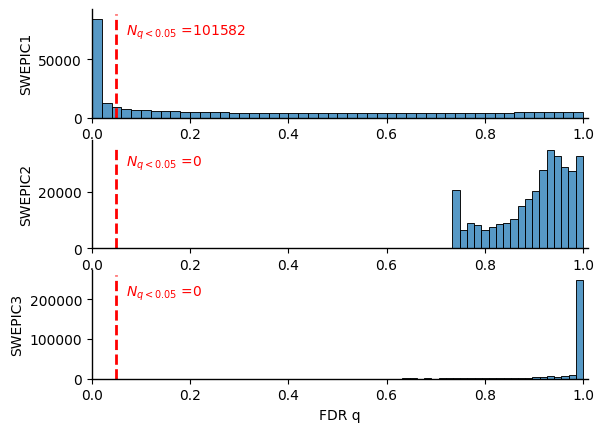

In [15]:
result_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/data/DMR_age_corr")

swepic1_dmr = pd.read_csv(result_dir / "SWEPIC1.csv",index_col=0).T

swepic1_dmr["FDR q"] = multipletests(swepic1_dmr["P>|z|"].ravel(),method="fdr_bh")[1]

swepic2_dmr = pd.read_csv(result_dir / "SWEPIC2.csv",index_col=0).T

swepic2_dmr["FDR q"] = multipletests(swepic2_dmr["P>|z|"].ravel(),method="fdr_bh")[1]

swepic3_dmr = pd.read_csv(result_dir / "SWEPIC3.csv",index_col=0).T

swepic3_dmr["FDR q"] = multipletests(swepic3_dmr["P>|z|"].ravel(),method="fdr_bh")[1]

all_dmrs = [swepic1_dmr, swepic2_dmr, swepic3_dmr]

threshpass = [(all_dmrs[i]["FDR q"]<0.05).sum() for i in range(len(all_dmrs))]

fig, ax = plt.subplots(3,1)
flatax = ax.flatten()
for i in range(len(flatax)):
    sns.histplot(data=all_dmrs[i].sort_values("FDR q"), x="FDR q", bins=50, ax = flatax[i])
    plting.pretty_ax(flatax[i])
    flatax[i].set_xlim([0,1.01])
    ymin, ymax = flatax[i].get_ylim()
    flatax[i].vlines(x=0.05, ymin=ymin, ymax=ymax, colors="r", ls="--", lw=2, label="FDR q=0.05")
    flatax[i].text(0.07, ymax*0.8, "$N_{q<0.05}$ ="+f"{threshpass[i]}", fontdict={"size": 10, "color": "r"})
    flatax[i].set_ylabel(f"SWEPIC{i+1}", size=10)
fig.savefig(fig_dir / "histplot_dmr_agecorrected.svg", bbox_inches="tight")

## Without age correction

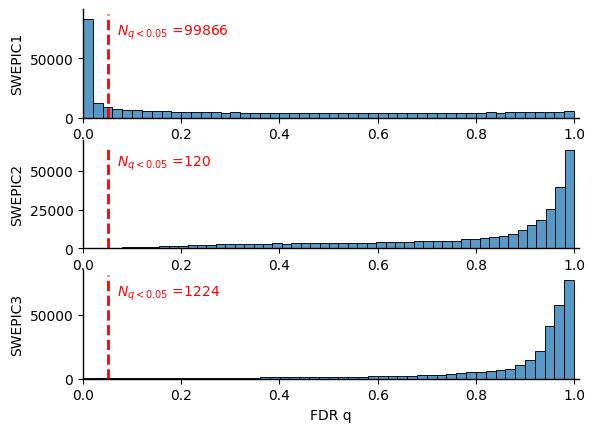

In [17]:
result_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/data/DMR_nocorr")

swepic1_dmr = pd.read_csv(result_dir / "SWEPIC1.csv",index_col=0).T

swepic1_dmr["FDR q"] = multipletests(swepic1_dmr["P>|z|"].ravel(),method="fdr_bh")[1]

swepic2_dmr = pd.read_csv(result_dir / "SWEPIC2.csv",index_col=0).T

swepic2_dmr["FDR q"] = multipletests(swepic2_dmr["P>|z|"].ravel(),method="fdr_bh")[1]

swepic3_dmr = pd.read_csv(result_dir / "SWEPIC3.csv",index_col=0).T

swepic3_dmr["FDR q"] = multipletests(swepic3_dmr["P>|z|"].ravel(),method="fdr_bh")[1]

all_dmrs = [swepic1_dmr, swepic2_dmr, swepic3_dmr]

threshpass = [(all_dmrs[i]["FDR q"]<0.05).sum() for i in range(len(all_dmrs))]

fig, ax = plt.subplots(3,1)
flatax = ax.flatten()
for i in range(len(flatax)):
    sns.histplot(data=all_dmrs[i].sort_values("FDR q"), x="FDR q", bins=50, ax = flatax[i])
    plting.pretty_ax(flatax[i])
    flatax[i].set_xlim([0,1.01])
    ymin, ymax = flatax[i].get_ylim()
    flatax[i].vlines(x=0.05, ymin=ymin, ymax=ymax, colors="r", ls="--", lw=2, label="FDR q=0.05")
    flatax[i].text(0.07, ymax*0.8, "$N_{q<0.05}$ ="+f"{threshpass[i]}", fontdict={"size": 10, "color": "r"})
    flatax[i].set_ylabel(f"SWEPIC{i+1}", size=10)
fig.savefig(fig_dir / "histplot_dmr_nocorr.svg", bbox_inches="tight")

# Compare to differential variability results

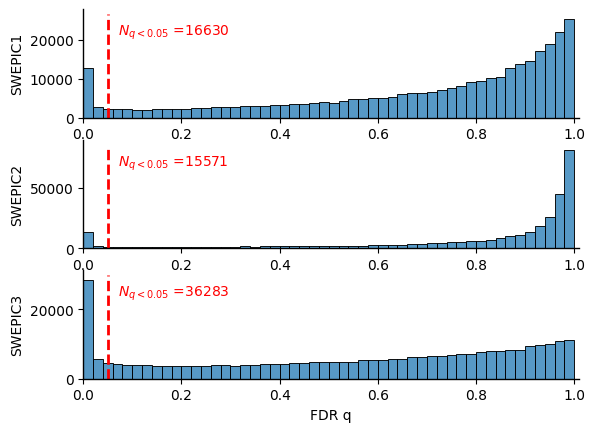

In [18]:
swepic1_dvc = pd.read_csv("../../FinalData/adVMP/adVMP_SWEPIC1_right.csv",index_col=0).rename(columns={"q": "FDR q"})
swepic2_dvc = pd.read_csv("../../FinalData/adVMP/adVMP_SWEPIC2_right.csv",index_col=0).rename(columns={"q": "FDR q"})
swepic3_dvc = pd.read_csv("../../FinalData/adVMP/adVMP_SWEPIC3_right.csv",index_col=0).rename(columns={"q": "FDR q"})

all_dvc = [swepic1_dvc, swepic2_dvc, swepic3_dvc]

threshpass = [(all_dvc[i]["FDR q"]<0.05).sum() for i in range(len(all_dvc))]

fig, ax = plt.subplots(3,1)
flatax = ax.flatten()
for i in range(len(flatax)):
    sns.histplot(data=all_dvc[i].sort_values("FDR q"), x="FDR q", bins=50, ax = flatax[i])
    plting.pretty_ax(flatax[i])
    flatax[i].set_xlim([0,1.01])
    ymin, ymax = flatax[i].get_ylim()
    flatax[i].vlines(x=0.05, ymin=ymin, ymax=ymax, colors="r", ls="--", lw=2, label="FDR q=0.05")
    flatax[i].text(0.07, ymax*0.8, "$N_{q<0.05}$ ="+f"{threshpass[i]}", fontdict={"size": 10, "color": "r"})
    flatax[i].set_ylabel(f"SWEPIC{i+1}", size=10)
fig.savefig(fig_dir / "histplot_dvc.svg", bbox_inches="tight")